In [2]:
import torch
import torch.optim as optim
import wandb
from environment import WaterTank, influx_function
from environment_JAX import WaterTank_Jax
from model import Policy, log_weights_and_derivatives
from plotting import plot_history
%load_ext autoreload
%autoreload 2

In [33]:
params = {
    "environment": {
        "time_step": 0.1,
        "target_level": 10,
        "initial_level": 10,
        "initial_time": 0,
        "max_outflux": 1,
    },
    "influx":{
        "amplitude": 0.25,
        "frequency": 0.1,
        "offset": 0.5
    },
    "model": {
        "input_size": 2,
        "hidden_size": 32,
        "output_size": 1
    },
    "optimizer": {
        "learning_rate": 1e-3
    },
    "run": {
        "num_epochs": 1000,
        "num_steps": 500
    }
}

wandb.init(
    project="Water Tank",
    name="run3",
    config=params
)

model = Policy(params)
# Load the saved parameters
# model.load_state_dict(torch.load('model_params.pth'))

optimizer = optim.Adam(model.parameters(), lr=params["optimizer"]["learning_rate"])

# Training loop
for epoch in range(params["run"]["num_epochs"]):
    water_tank = WaterTank(params)

    for step in range(params["run"]["num_steps"]):
        influx = influx_function(water_tank.time, params)
        state = torch.tensor([water_tank.level, influx], dtype=torch.float32)

        outflux_percentage = model(state)

        # Take a step in the environment
        reward = water_tank.step(outflux_percentage, influx)

        if step + 1 == params["run"]["num_steps"]:
            # save the weights before the update
            prev_weights = [param.detach().clone() for param in model.parameters()]

        # Update the policy using the reward and gradients
        optimizer.zero_grad()
        reward.backward()
        optimizer.step()

    # Log the episode reward and other relevant information
    log_weights_and_derivatives(model, prev_weights)
    wandb.log(
        {
            "loss": reward.item(),
            "level": water_tank.level.item(),
            "outflux percentage": outflux_percentage.item()
        }
    )

# Save the model's parameters to a file
torch.save(model.state_dict(), 'model_params.pth')

wandb.finish()

level,▁▄█████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
max_abs_gradient,▁▃▆▆▆▆▆▆▆▇▇▇▇▆▆▆▇▇▇▇▇▆▇▇▇▇▆▆▇▇▇▇██▇█▇▇█▇
max_abs_weight,▁▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
max_abs_weight_change,▆▄▄▄▅▄▅▅▄▄▅▄█▅▃▃▃▄▃▄▄▁▄▄▄▄▄▂▄▂▄▄▄▁▄▄▂▄▁▂
mean_abs_gradient,▁▃█████▇▅▅▅▅▅▅▄▃▄▄▄▄▄▄▄▄▄▄▃▃▄▃▃▃▃▃▂▄▃▃▃▃
mean_abs_weight,▁▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
mean_abs_weight_change,█▇▅▆▆▆▇▇▅▅▆▅▆▆▄▄▅▆▅▅▅▁▆▅▅▆▅▃▅▃▅▅▆▂▅▅▂▅▁▃
outflux percentage,▁▃▂▃▄▅▇▇▄▄▇▅▇█▄▃▅▇▅▆▇▃█▆▇▇▃▃▇▃▆▆▆▆▃▆▃▄▆▃
level,9.95572
loss,0.04428


In [ ]:
wandb.finish()

# Run One Episode

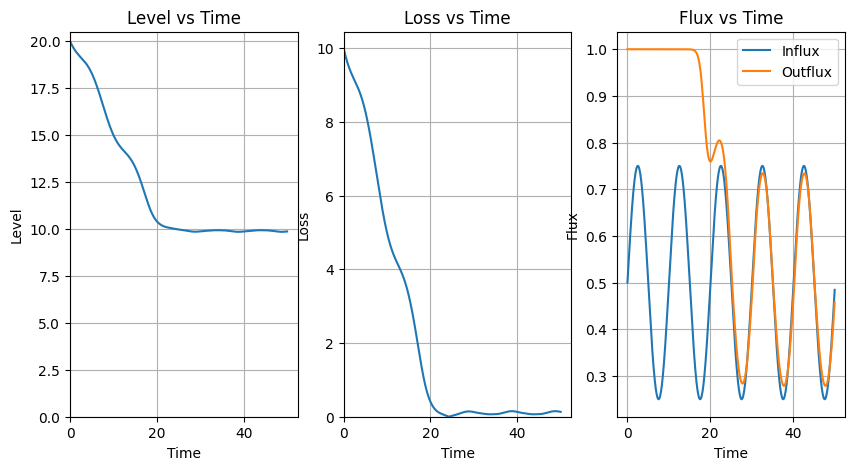

In [4]:
params = {
    "environment": {
        "time_step": 0.1,
        "target_level": 10,
        "initial_level": 20,
        "initial_time": 0,
        "max_outflux": 1,
    },
    "influx":{
        "amplitude": 0.25,
        "frequency": 0.1,
        "offset": 0.5
    },
    "model": {
        "input_size": 2,
        "hidden_size": 32,
        "output_size": 1
    },
    "run": {
        "num_epochs": 1,
        "num_steps": 500
    }
}

# Initialize the environment and the policy
model = Policy(params)

# Load the saved parameters
model.load_state_dict(torch.load('model_params.pth'))

water_tank = WaterTank(params)

for step in range(params["run"]["num_steps"]):
    # Prepare the input for the policy network (current_level and next_step_influx)
    influx = influx_function(water_tank.time, params)
    state = torch.tensor([water_tank.level, influx], dtype=torch.float32)

    # Get the outflux_percentage from the policy
    outflux_percentage = model(state)

    # Take a step in the environment
    reward = water_tank.step(outflux_percentage, influx)

plot_history(*water_tank.get_history())

# Jax

In [ ]:
params = {
    "model": {
        "input_size": 2,
        "hidden_size": 32,
        "output_size": 1
    },
    "optimizer": {
        "learning_rate": 1e-3
    },
    "run": {
        "num_epochs": 1000,
        "num_steps": 500
    }
}



In [6]:
a = {}
print(not "test" in a)

True
